# Fully convolutional network for semantic segmentation

Semantic segmentation belongs to scene understanding field, and it is the task of assigning meaning to a part of an object. This can be done at the pixel level where we assign each pixel to a target class.

The goal is to input an image into a neural network and output a category for every pixel. We'll have a set of categories, much like in a classification task. But instead of assigning a single class to an image we want to assign a class to every pixel in that image.

FCNs achieves state-of-art in tasks like semantic segmentation, by taking advantage of three special techniques:
- Replace fully connected layers with one by one convolutional layer.
- Up-sampling through the use of transposed convolutional layers.
- Adding skip connections. (This allows the network to use information from multiple resolution scales)

This network takes in an image that has true labels attached to each pixel and then it outputs a tensor with dimension:``` classes x height x width. ```

**FCN limitations**

- It is very expensive to label every pixel.
- It is computationally expensive to maintain spatial information in each convolutional layer.

## Set up Google Colab

### Connect with Google drive 

In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN")


### Confirm that PIL works
Give **image_path** varible the path name of the image you want to display.

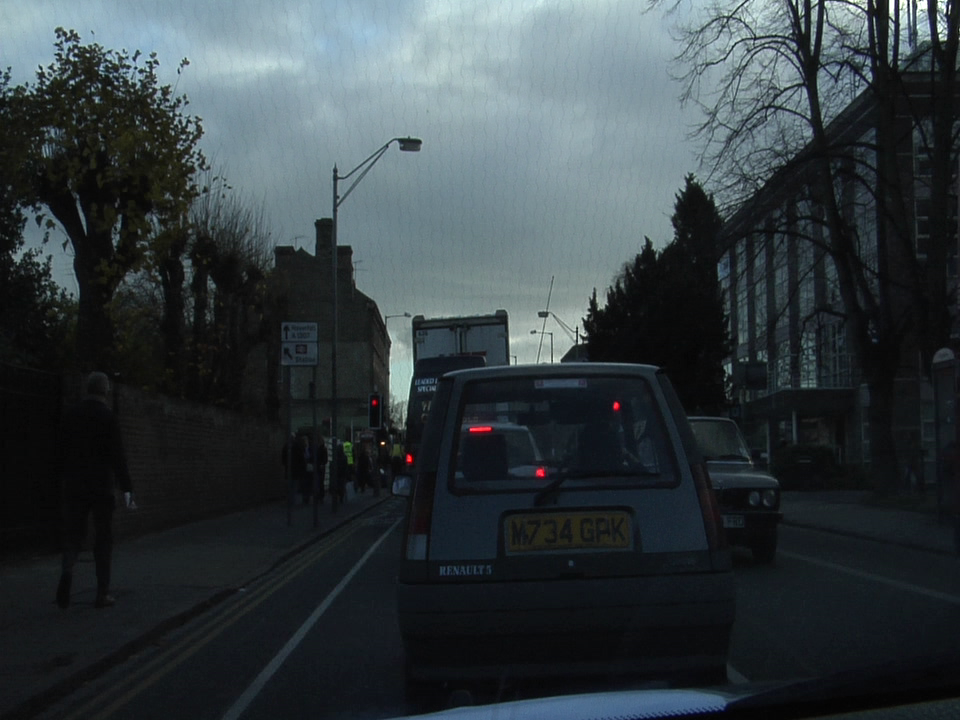

In [3]:
from PIL import Image
image_path = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train/0001TP_009210.png"
Image.open(open(image_path,"rb"))

## Imports 

In [4]:
!pip install tikzplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 6.7 MB/s eta 0:00:00


In [5]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random
import imageio

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset



In [1]:
from util.pool_select import get_pool
from util.wavelet_pool2d import AdaptiveWaveletPool2d, StaticWaveletPool2d

ModuleNotFoundError: ignored

## Utility Functions for Wavelet Pooling

## Data

[CamVid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) is a motion-based segmentation and recognition [dataset](https://github.com/mostafaizz/camvid) that contains 701 images, 701 labeled images, and a file with a list of classes with their correspondence in RGB code. 

**NOTE:** 
I pre-processed the labeled images by changing their RGB values for class ids. Instead of doing it directly on the CamVid class, do it separately and save the result as a .npy file to improve the performance ([Here](https://towardsdatascience.com/why-you-should-start-using-npy-file-more-often-df2a13cc0161) is an interesting article about that). In this way you cannot use PyTorch transforms on a label image, since PIL will change the class id for color values. Also, CamVid images are very similar, so adding augmentation like RandomCrop or RandomHorizontalFlip helps the network.

### Load data

In [7]:
class CamVid(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
    if phase == 'train':
      self.input_shape = (480, 640)
    elif phase == 'valid' or phase == 'test':
      self.input_shape = (704, 960)
  
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = imageio.imread(image)
    label = np.load(label)
        
    if self.phase == "train":
      # RandomCrop
      h, w, _ = image.shape
      new_h, new_w = self.input_shape
      
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      image = image[top:top + new_h, left:left + new_w]
      label = label[top:top + new_h, left:left + new_w]
      
      # RandomHorizontalFlip
      if random.random() < 0.5:
        image = np.fliplr(image)
        label = np.fliplr(label)
        
    if self.phase == "valid" or self.phase == "test":
      # "Resize"
      new_h, new_w = self.input_shape
      
      image = image[0:new_h, 0:new_w]
      label = label[0:new_h, 0:new_w]
          
    # Normalization 
    mean=[0.485, 0.456, 0.460]
    std =[0.229, 0.224, 0.225]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]
    
    # ToTensor 
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(label.copy()).long()
  
    # One-hot encoding
    h, w = label.size()
    target = torch.zeros(32, h, w)
    for c in range(32):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label} 
  
  def __len__(self):
    return len(self.data) 

train_data = CamVid('/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/csv_files/train.csv', phase="train")
valid_data = CamVid('/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/csv_files/val.csv', phase="valid")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)

print(len(train_data))
print(len(valid_data))

369
100


### Visualize a single batch

<ipython-input-7-75529dd140e7>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image)


torch.Size([5, 3, 480, 640]) torch.Size([5, 32, 480, 640]) torch.Size([5, 480, 640])


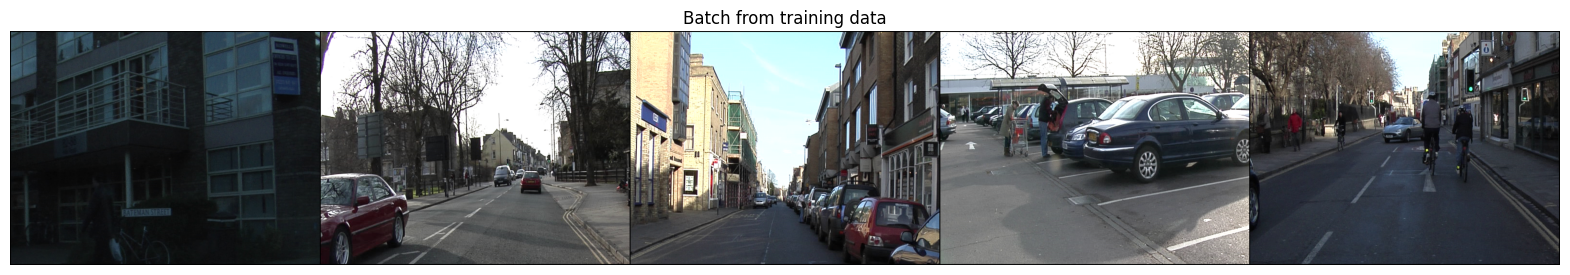

In [8]:
def show_batch(batch):
  mean=[0.485, 0.456, 0.460]
  std =[0.229, 0.224, 0.225]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

Its goal is to extract features from the image. In this case, I used the pretrained VGG16 model and removed the classifier (the fully connected layer at the end).  Doing so casts it into a fully convolutional network that outputs classification maps (heatmaps). Also saved the score of three different pooling layers that the decoder will use to perform skip connections.

In [15]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        # print(x.size())
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    """for layer_name, layer in output.items():
      print(layer_name, " ", layer.size())"""
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    first = True
    for v in cfg:
      if v == 'M':
        #layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        layers += [get_pool(pool_type='wavelet', scales=1)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

It up-scales the output of the encoder such that it's the same size as the original image.

- **Convolutional score layer** - This will result in the output of a 4D tensor instead of a flattened 2D tensor, so spatial information will be preserved. Effectively, this turns convolutions into a matrix multiplication with spatial information. The number of kernels is equivalent to the number of outputs. 

- **Transposed convolutions** - Is essentially a reverse convolution in which the forward and the backward passes are swapped. They help in upsampling the previous layer to a higher resolution or dimension.  

- **Skip connections** - They allow the network to use information from multiple resolutions, and as a result, the network is able to make more precise segmentation decisions.

In [10]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']

    #print(f'pool_5 size = {pool_5.size()}')
    x = self.relu(self.deconv1(pool_5))
    #print(f'x size = {x.size()}')
    #print(f'pool_4 size {pool_4.size()}')
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [11]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

###  Test output sizes

In [12]:
batch_size, n_classes, h, w = 10, 20, 160, 160

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 224, 224)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 7, 7])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

static wavelet
static wavelet
static wavelet
static wavelet
static wavelet


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 266MB/s]


Correct output sizes


## Train model

### Set training parameters

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [14]:
# Define model
n_classes = 32
model = FCN8s(VGG16(cfg, ranges), n_classes)
model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 50
print_every = 20

# Define scores
IoU_scores = np.zeros((epochs, n_classes))
pixel_scores = np.zeros(epochs)

static wavelet
static wavelet
static wavelet
static wavelet
static wavelet
FCN8s(
  (pretrained_model): VGG16(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): StaticWaveletPool2d()
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): StaticWaveletPool2d()
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): StaticWaveletPool2d(

### Check accuracy before training

In [ ]:
def iou(y_hat, y):
  ious = []
  for c in range(n_classes):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total

def average_accuracy(y_hat, y):
  class_total_pixel = [0]*33
  class_correct_pixel = [0]*33
  for i in range(len(y)):
    for j in range(len(y[0])):
      class_total_pixel[y[i][j]] += 1
      if(y[i][j] == y_hat[i][j]):
        class_correct_pixel[y[i][j]] += 1

  class_correct_pixel = np.array(class_correct_pixel, dtype=float)
  class_total_pixel = np.array(class_total_pixel, dtype=float)
  avg_acc = np.divide(class_correct_pixel, class_total_pixel, out=np.zeros_like(class_correct_pixel), where=class_total_pixel!=0)
  return avg_acc.sum() / n_classes



def validation(model, validloader, criterion):
  total_ious = []
  pixel_accs = []
  avg_accs = []
  for i, batch in enumerate(validloader):
    inputs = batch['x'].to(device)
    output = model(inputs)
    output = output.data.cpu().numpy()
        
    N, _, h, w = output.shape 
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
    target = batch['l'].cpu().numpy().reshape(N, h, w)
    
    for y_hat, y in zip(pred, target):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
      avg_accs.append(average_accuracy(y_hat, y))

  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()


  avg_acc = np.array(avg_accs).mean()
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  return pixel_acc, avg_acc, mean_iou

### Train

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-wavelet.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
best = 0

f = open("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/metrics/Wavelet_metrics.txt", "w")
for epoch in range(50, epochs+20):
  
  for i, batch in enumerate(trainloader):
    inputs, labels = batch['x'].to(device), batch['y'].to(device)
    optimizer.zero_grad()
    
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      model.eval()
      with torch.no_grad():
        paccuracy, avg_accuracy, meaniou = validation(model, validloader, criterion)
  
      if best < meaniou:
        torch.save(model.state_dict(), "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-wavelet.pth")
        best = meaniou
      model.train()
  print("Epoch: {}/{}.. ".format(epoch+1, epochs),
        "Training loss: {:.5f}.. ".format(loss.item()),
        "Pixel accuracy.. {:.5f}".format(paccuracy),
        "Mean IU.. {:.5f}".format(meaniou))
  
  f.write("Epoch: " + str(epoch+1) + " Training loss: " + str(loss.item()) + " Pixel accuracy: " + str(paccuracy) + " Mean IoU: " + str(meaniou) + "\n")

f.close()

## Test

In [ ]:
test_data = CamVid('/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/csv_files/test.csv', phase="test")
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)
print(len(test_data))

232


In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-wavelet.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
  pixel_acc, avg_accuracy, mean_iou = validation(model, testloader, criterion)
model.train()
print("Pixel accuracy: ", pixel_acc, " Average Accuracy: ", avg_accuracy, " Mean IoU: ", mean_iou)

<ipython-input-7-75529dd140e7>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image)


Pixel accuracy:  0.8569382431365106  Average Accuracy:  0.2566571792228629  Mean IoU:  0.2191659736744256


<ipython-input-37-c6d027130fc0>:69: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))


## Make inference

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-wavelet.pth")
model.load_state_dict(state_dict)

In [ ]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None
  
#Id : [Label, (RGB code)]
gt_labels = {1 : ["Animal", (64, 128, 64)],
            2 : ["Archway", (192, 0, 128)],
            3 : ["Bicyclist", (0, 128, 192)],
            4 : ["Bridge", (0, 128, 64)],
            5 : ["Building", (128, 0, 0,)],
            6 : ["Car", (64, 0, 128)],
            7 : ["CartLuggagePram", (64, 0, 192)],
            8 : ["Child", (192, 128, 64)],
            9 : ["Column_Pole", (192, 192, 128)],
            10: ["Fence", (64, 64, 128)],
            11: ["LaneMkgsDriv", (128, 0, 192)],
            12: ["LaneMkgsNonDriv", (192, 0, 64)],
            13: ["Misc_Text", (128, 128, 64)],
            14: ["MotorcycleScooter", (192, 0, 192)],
            15: ["OtherMoving", (128, 64, 64)],
            16: ["ParkingBlock", (64, 192, 128)],
            17: ["Pedestrian", (64, 64, 0)],
            18: ["Road", (128, 64, 128)],
            19: ["RoadShoulder", (128, 128, 192)],
            20: ["Sidewalk", (0, 0, 192)],
            21: ["SignSymbol", (192, 128, 128)],
            22: ["Sky", (128, 128, 128)],
            23: ["SUVPickupTruck", (64, 128, 192)],
            24: ["TrafficCone", (0, 0, 64)],
            25: ["TrafficLight", (0, 64, 64)],
            26: ["Train", (192, 64, 128)],
            27: ["Tree", (128, 128, 0)],
            28: ["Truck_Bus", (192, 128, 192)],
            29: ["Tunnel", (64, 0, 64)],
            30: ["VegetationMisc", (192, 192, 0)],
            31: ["Void", (0, 0, 0)],
            32: ["Wall", (64, 192, 0)]}	

In [ ]:
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

inference_transforms = transforms.Compose([ transforms.Resize((704,960)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.460],[0.229, 0.224, 0.225])])
def load_image(image):
  if isinstance(image, str):
    image = Image.open(image).convert('RGB')
  else:
    image = Image.fromarray(image).convert('RGB')
  image = inference_transforms(image)
  image = torch.tensor(image, requires_grad=False)
  image = image.unsqueeze(0)
  return image

def get_predicted_image(original, prediction, labels=None):
  _, h, w = prediction.shape
  _, oh, ow = original.shape
  if h != oh or w != ow:
    #original = scipy.misc.imresize(original, (704, 960))
    original = np.array(Image.fromarray(original).resize((704, 960)))
    #numpy.array(Image.fromarray(arr).resize())
  output = np.zeros((h, w, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      index = prediction[0][i][j] + 1
      try:
        if labels is not None:
          if index in labels:
            color = gt_labels.get(index)[1]
            output[i, j, 0] = color[0]
            output[i, j, 1] = color[1]
            output[i, j, 2] = color[2]
          else:
            output[i, j, 0] = original[i, j, 0]
            output[i, j, 1] = original[i, j, 1]
            output[i, j, 2] = original[i, j, 2]
        else:
          color = gt_labels.get(index)[1]
          output[i, j, 0] = color[0]
          output[i, j, 1] = color[1]
          output[i, j, 2] = color[2]
      except:
        print("Upss, didn't work")
        break
  return output

def get_image_labels(testimage):
  model.to(device)
  model.eval()
  image = load_image(testimage)
  prediction = model(image.to(device))
  prediction = prediction.data.cpu().numpy()
  N, _, h, w = prediction.shape
  prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, 32).argmax(axis=1).reshape(N, h, w)
  return prediction

### Compare prediction with ground truth

In [ ]:
name = "Seq05VD_f01800"

inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train/" + name + ".png"
tru_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train_labels/" + name + "_L.png"

original = imageio.imread(inp_image)
truth = imageio.imread(tru_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))

plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

### Predict on an unlabeled image 

In [ ]:
inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/val/0016E5_08045.png"

original = imageio.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

### Segment a selected group of labels

In [ ]:
# name = "Seq05VD_f01800"

# inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train/" + name + ".png"
# tru_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train_labels/" + name + "_L.png"

# original = imageio.imread(inp_image)
# truth = imageio.imread(tru_image)
# predicted = get_predicted_image(original, get_image_labels(inp_image), [11, 12, 18, 19]) # Only road labels

# plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

In [ ]:
# inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/test/0001TP_006720.png"

# original = imageio.imread(inp_image)
# predicted = get_predicted_image(original, get_image_labels(inp_image), [11, 12, 18, 19]) # Only road labels
   
# plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

### Inference on video

In [ ]:
# import glob
# import os 
# import cv2

# def get_frame_rate(video):
#     video = cv2.VideoCapture(video);
#     # Find OpenCV version
#     (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
#     if int(major_ver)  < 3 :
#         fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
#         print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(int(fps)))
#     else :
#         fps = video.get(cv2.CAP_PROP_FPS)
#         print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(int(fps)))
#     video.release();
#     return int(fps)
    
# def process_video(video, path_to_save):
#     cap = cv2.VideoCapture(video)
#     print("Number of frames: ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
#     ret, frame = cap.read()
#     cont = 0
#     while ret:
#         if cont < 10000:
#           #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#           prediction = get_predicted_image(frame, get_image_labels(frame), [11, 12, 18, 19]) # Only road labels
#           cv2.imwrite(path_to_save + str(cont) + ".png", prediction)
#         cont += 1
#         ret, frame = cap.read()
#     print(cont)
#     print("Video processed.")

# def make_video(outvid, images=None, fps=30, size=None, is_color=True, format="FMP4"):
#     fourcc = cv2.VideoWriter_fourcc(*format)
#     vid = None
#     for image in images:
#         if not os.path.exists(image):
#             raise FileNotFoundError(image)
#         img = cv2.imread(image)
#         if vid is None:
#             if size is None:
#                 size = img.shape[1], img.shape[0]
#             vid = cv2.VideoWriter(outvid, fourcc, float(fps), size, is_color)
#         if size[0] != img.shape[1] and size[1] != img.shape[0]:
#             img = cv2.resize(img, size)
#         vid.write(img)
#     vid.release()
#     return vid
    
# def detect_on_video(video, out_path, fps):
#     # Process video to get all the frames with detections
#     process_video(video, out_path)
#     # Get processed frames and order by name
#     images = list(glob.iglob(os.path.join(out_path, '*.png')))
#     images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
#     # Create the video from processed frames
#     make_video(out_path+"output.mp4", images, fps)
#     print("Video: "+ out_path +" output.mp4 it's ready")

# video = '/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/video/Driving - 800.mp4'
# path = '/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/Dump/'

# fps = get_frame_rate(video)
# detect_on_video(video, path, fps+1)

### Video output (converted as GIF) 

# ![Video-output](/images/outputgif.gif)